# Graph neural network - CaMML course

# Introduction

# Graph theory

# How to do a GNN?

Thanks to this approach we can transform the theory into an useable algorithm.

To do so, we will take the time to build piece by piece our own GNN in this section. 

First of all, we need to have access to a sufficient amount of data to train our GNN, for this, the __[Material Project](https://legacy.materialsproject.org/)__ database will be used. Even if we could train our GNN upon any property, we will only focus on the prediction of the formation energy of the solid using its structure and its composition.

The extraction and handeling of the data will be similar to what is shown in the [matminer tutorial](https://github.com/hackingmaterials/matminer_examples/blob/main/matminer_examples/).

In [1]:
# Here we will take some libraries to construct the neural-networks using torch.
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

# Here are some diverse modules and functions necessary.
import random
import time

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

# ASE and pymatgen modules
from pymatgen.io.ase import AseAtomsAdaptor
from ase.neighborlist import neighbor_list

# matminer
# Be mindful that the MPDataRetrieval only works for the old MP data base!
from matminer.data_retrieval.retrieve_MP import MPDataRetrieval

/home/lorentyfle/test/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data aquisition

In [2]:
# To ensure a reproducible results, we put the same random seed.
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
mpdr = MPDataRetrieval("") # I am using MP because the other one crashes and I have enough of waiting 1h just for it to crash.

/home/lorentyfle/test/.venv/lib/python3.10/site-packages/pymatgen/ext/matproj.py:419: FutureWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  return _MPResterLegacy(*args, **kwargs)


In [4]:
# Can be long (~10min to grab all the necesary 126335 datas).
df = mpdr.get_dataframe(criteria={}, properties=['formation_energy_per_atom', 'pretty_formula',"structure"])

100%|██████████| 126335/126335 [10:53<00:00, 193.34it/s]


Now that the data base is ready, with only three columns needed to train our GNN upon:
 - The composition
 - The structure
 - The formation energy (the property we wish to predict)
 

In [5]:
df

,formation_energy_per_atom,pretty_formula,structure
material_id,,,
mp-1001788,-0.020860,ZrB6,"[[0. 0. 0.] Zr, [0.80207057 2.029387 2.02938..."
mp-1002206,0.537123,SiC,"[[0. 0. 0.] Si, [2.0251 2.0251 2.0251] C]"
mp-1004524,0.234287,HPbI3,"[[3.1221065 3.1221065 3.1221065] H, [0. 0. 0.]..."
mp-1008492,-0.349239,BrCl,"[[0. 0. 0.] Br, [0. 0. 3.9053505..."
mp-1011260,-2.517135,EuFeO3,"[[ 2.747224 2.72097164 -1.9501425 ] Eu, [5...."
...,...,...,...
mvc-5634,-2.022086,Ca2CuIrO6,"[[3.15778709 8.03614231 5.77105139] Ca, [0.340..."
mvc-6019,-1.619846,Zn(SnO2)2,"[[ 0. 11.36829898 1.84505467] Zn, [0...."
mvc-8011,-1.584384,ZnFeAs2O7,"[[0.71270026 8.84632777 7.89206318] Zn, [5.112..."


If we then look at the repartition of the *formation energy per atom* in function of the database, we have the histogram below.

[Text(0.5, 0, '$\\mathrm{E}_\\mathrm{f}/\\mathrm{atom}$'),
 Text(0, 0.5, 'Number of examples')]

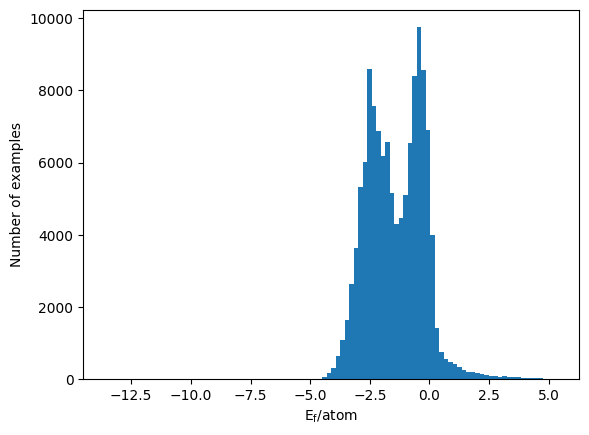

In [6]:
fig, ax = plt.subplots()
ax.hist(df["formation_energy_per_atom"], bins=100)
ax.set(xlabel="$\mathrm{E}_\mathrm{f}/\mathrm{atom}$", ylabel="Number of examples")

## Transforming the data into a graph.

    Transforming a structure into a graph.

At last we have a curated database in function of the target property, the formation energy.

Yet, we still lacks a graph representation of the structure using node and edges. To do so, we can say that each atoms of each structures are a **node** and, their neigbhor the **edges**.

    Encoding information.

As the edge and the node is defined, one last step still remains before the data is ready, we need to encode some informations inside the node and the edge to allow the machine learning to know the difference in between a Li next to an O and a I next to a Fe.


_Where can we encode the information?_

Saving information inside the node seems very intuitive because we simply say that one node is one atom, such that the information of the atom type seems obvious.

As for the interactions, we can store this information inside the edges of the node, this is the **edge embedding**.

The simplest edge embedding would be the atomic connexion; yet, we can also store further informations like the bond length, the bond angle, etc...

Here we will be modest and only keep the atomic connexion and the bond length as edge features (similar to a crystal graph convolutional neural networks).

### The Node: Encoding the nature of the atom

To encode the nature of the atom, one simple way would be to make an array of 118 entries (for each atoms), then put a 1 where this atom is inside the periodic table of elements.

This method called *one hot encoding* is here useful because it will reduce drastically the memory needed to identify the data base while being really easy to read.

In [7]:
def one_hot_encode_z(atomic_number:int):
    """We return a onehot encoding of the periodic table of elements, inputting the Z number gives the good onehot encoding for the atom in question."""
    vector = np.zeros(118)
    vector[atomic_number-1] = 1
    return vector

In [8]:
node_features = torch.tensor([one_hot_encode_z(site.species.elements[0].Z) for site in df["structure"].iloc[0]])
# Here our atom is Zr with Z=40, so we look at the 39th place to find it back.
print(node_features[0][39])
print(node_features[0])

tensor(1., dtype=torch.float64)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)


/tmp/ipykernel_1082/1130799710.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  node_features = torch.tensor([one_hot_encode_z(site.species.elements[0].Z) for site in df["structure"].iloc[0]])


### The Edge : Keeping track of the atom connexions.

Keeping track of the atom connexion is not as hard has one may think. Indeed, we can simply use a prebuilt function inside [`ase`](https://wiki.fysik.dtu.dk/ase/) to output the list of neighboring connexions and their length given a cutoff radius.

In [9]:
cutoff_radius = 4 # Angstrom

In [48]:
atoms = AseAtomsAdaptor.get_atoms(df["structure"].iloc[0])
edge_src, edge_dst, edge_len = neighbor_list(
                "ijd", atoms, cutoff=cutoff_radius, self_interaction=False
            )
# Cell parameter of atoms
atoms.cell

Cell([4.058774, 4.058774, 4.058774])

The three variables show the origin of the bond, its destination and the length.
In fact, if we visualize the graph of the connections it becomes evident that for such a crystal structure with cell parameters almost equal to $4 \AA$, each of the atoms will be connected.

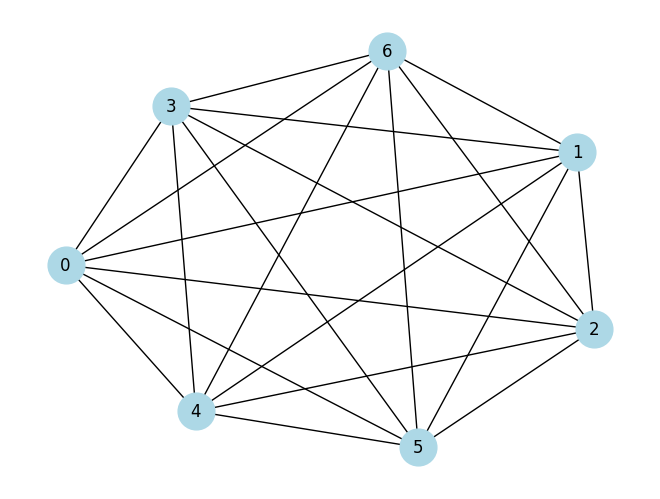

In [53]:
G = nx.Graph()
for s1, s2 in zip(edge_src, edge_dst):
    G.add_edge(s1, s2)
nx.draw(G, with_labels=True, node_color='lightblue', node_size=700, font_size=12)
plt.show()

### The Edge : Length of the connexion.

We have the connexions and the length so, what are we waiting for?

In fact, it would not be wise to use the bond length value for the connexion, a single value would not be enough for the GNN to assess a pattern with distances while having a good description of the environment.

One way would be to embbed the edges using a basis set of gaussians that will describe the space in between $0$ and $4 \AA$, in which the bond length will be mapped.

In [12]:
# How many gaussian to describe this space?
number_of_gaussians = 80

In [13]:
# one hot encode bond length using gaussians.
filter = np.linspace(0, cutoff_radius, number_of_gaussians)
edge_feat = np.exp(
    -((edge_len[..., None] - filter) ** 2) / (filter[1] - filter[0]) ** 2
)

## Storing the data

Once we did all of this, we can try to store all this informations inside a Data class that will possess all the informations of our database.

In [14]:
from torch_geometric.data import Data
from tqdm import tqdm
# Parameters for encoding bond lengths
cutoff_radius = 4.0 
number_of_gaussians = 10
number_of_random_structures_taken = 1000

filter = np.linspace(0, cutoff_radius, number_of_gaussians)

# Initialize an empty list to store Data objects
data_list = []

# I take a smaller sample size to go quicker. Only random structures are here taken to not be biased.
sampled_df = df.sample(n=number_of_random_structures_taken, random_state=SEED)

# Loop through each entry in the DataFrame
for entry in tqdm(range(sampled_df.shape[0])):
    # Extract ASE Atoms object from the structure
    atoms = AseAtomsAdaptor.get_atoms(df["structure"].iloc[entry])
    
    # Use neighbor_list to compute edge_src, edge_dst, and edge_len
    edge_src, edge_dst, edge_len = neighbor_list(
        "ijd", atoms, cutoff=cutoff_radius, self_interaction=False
    )
    
    # One-hot encode bond lengths using Gaussian distributions
    edge_feat = np.exp(
        -((edge_len[..., None] - filter) ** 2) / (filter[1] - filter[0]) ** 2
    )
    edge_feat = torch.tensor(edge_feat, dtype=torch.float)
    
    # Create node features (example: one-hot encode atomic numbers)
    node_features = torch.tensor([
        one_hot_encode_z(site.species.elements[0].Z)
        for site in df["structure"].iloc[entry]
    ], dtype=torch.float)
    
    # Create edge_index from edge_src and edge_dst
    edge_index = torch.tensor([edge_src, edge_dst], dtype=torch.long)

    # Setup the target of our small GNN
    target = torch.tensor(sampled_df["formation_energy_per_atom"].iloc[entry], dtype=torch.float)

    # Create a Data object for the current entry
    data = Data(
        x=node_features,  # Node features
        edge_index=edge_index,  # Edge connections
        edge_attr=edge_feat,  # Edge features (Gaussian encoded bond lengths)
        y=target
    )
    
    # Append the Data object to the list
    data_list.append(data)


100%|██████████| 1000/1000 [00:41<00:00, 24.26it/s]


Now that our data base is created, we can start to split it up in between a **training set**, a **testing set** and a **validation set**.

 - The training set is the set of data that will be used for training the model.
 - The validation set is the set of data that will be used to help the training of the model by showing verifications on untrained data, giving a score to train once again.
 - The testing set is the set of data that will be used to know how well the model can predict on unseen datas.

In [15]:
# State in percentage the amount of training, testing and validation data. It must be equal to 1 at the end.
proportions = [0.8,0.1,0.1]

In [16]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

def proportion_to_percentage(proportion:list,precision:int=4):
    """proportion = [training, testing, validation]"""
    if round(sum(proportion),precision) != 1:
        raise ValueError("The sum of all proportions of the data cannot be different from 1.")
    # Training split
    train_split = round(1 - proportion[0],precision)
    # Testing split
    test_split  = round((1 - proportion[1]/(proportion[1]+proportion[2])),precision)
    return train_split, test_split

In [17]:
train_split, test_split = proportion_to_percentage(proportions)
#
train_data, temp_data = train_test_split(data_list, test_size=train_split, random_state=SEED)
test_data, val_data   = train_test_split(temp_data, test_size=test_split, random_state=SEED)


# Create a DataLoader for batching the graphs
train_loader = DataLoader(train_data, batch_size=32, shuffle=True) # We do not want correlation of the input order for the training data
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

## Making the GNN

To construct the GNN, we can split the task into two parts:
 - GNN class
 - Training and evaluation function

### GNN class

> ``The fitting of the GNN links``

First of all, the GNN we are constructing will take **n** inputs going through **x** hidden channels for only **one** output, *the formation energy*.

Such that we will first have a combination of convolutions in between each hidden layers and the previous layer as it was discussed previously in the theory; yet, to compute the output layer which only needs one dimension, a linear transformation is used to fit all the previous layers toward a single solution.

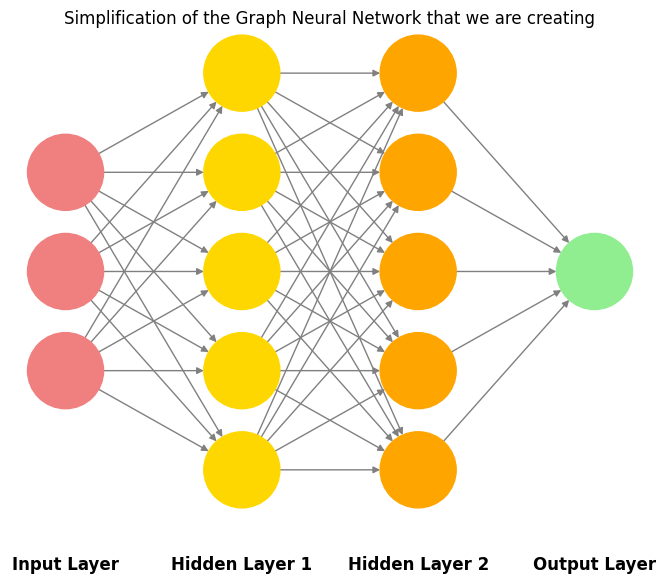

In [54]:
import matplotlib.pyplot as plt
import networkx as nx

# Create graph object
G = nx.DiGraph()

# Define nodes for each layer
input_layers = [f'Input {i+1}' for i in range(3)]  # Three input nodes
hidden_layers1 = [f'Hidden 1\nNode {i+1}' for i in range(5)]  # First hidden layer (5 nodes)
hidden_layers2 = [f'Hidden 2\nNode {i+1}' for i in range(5)]  # Second hidden layer (5 nodes)
output_layer = ['Output']  # Single output node

# Add nodes to the graph
for node in input_layers + hidden_layers1 + hidden_layers2 + output_layer:
    G.add_node(node)

# Add edges between layers
for input_node in input_layers:
    for hidden_node in hidden_layers1:
        G.add_edge(input_node, hidden_node)
for hidden_node1 in hidden_layers1:
    for hidden_node2 in hidden_layers2:
        G.add_edge(hidden_node1, hidden_node2)
for hidden_node2 in hidden_layers2:
    G.add_edge(hidden_node2, output_layer[0])

# Define positions for organized columns
pos = {}
# Input layer (centered in the left column)
for i, node in enumerate(input_layers):
    pos[node] = (0, i - (len(input_layers) - 1) / 2)  # Center nodes around 0 vertically
# First hidden layer (second column)
for i, node in enumerate(hidden_layers1):
    pos[node] = (1, i - (len(hidden_layers1) - 1) / 2)  # Center nodes around 0 vertically
# Second hidden layer (third column)
for i, node in enumerate(hidden_layers2):
    pos[node] = (2, i - (len(hidden_layers2) - 1) / 2)  # Center nodes around 0 vertically
# Output layer (right column, center node vertically)
pos[output_layer[0]] = (3, 0)

# Assign colors based on node types
node_colors = []
for node in G.nodes():
    if "Input" in node:
        node_colors.append('lightcoral')  # Input nodes: Red
    elif "Hidden 1" in node:
        node_colors.append('gold')  # First hidden layer: Yellow
    elif "Hidden 2" in node:
        node_colors.append('orange')  # Second hidden layer: Orange
    elif "Output" in node:
        node_colors.append('lightgreen')  # Output node: Green

# Draw the graph with custom colors and positions, increasing node size
nx.draw(
    G, pos, with_labels=False, node_size=3000,  # Increased node size
    node_color=node_colors, font_size=10, font_weight='bold', edge_color='gray'
)

# Add text labels for the hidden layers below the nodes
plt.text(0, -3, 'Input Layer', fontsize=12, fontweight='bold', ha='center', color='black')
plt.text(1, -3, 'Hidden Layer 1', fontsize=12, fontweight='bold', ha='center', color='black')
plt.text(2, -3, 'Hidden Layer 2', fontsize=12, fontweight='bold', ha='center', color='black')
plt.text(3, -3, 'Output Layer', fontsize=12, fontweight='bold', ha='center', color='black')

plt.title('Simplification of the Graph Neural Network that we are creating')
plt.show()

> ``The fitting of the nodes``

Here the node of each layers are fitted using a non linear function called a reLU function that we can see the plot below:

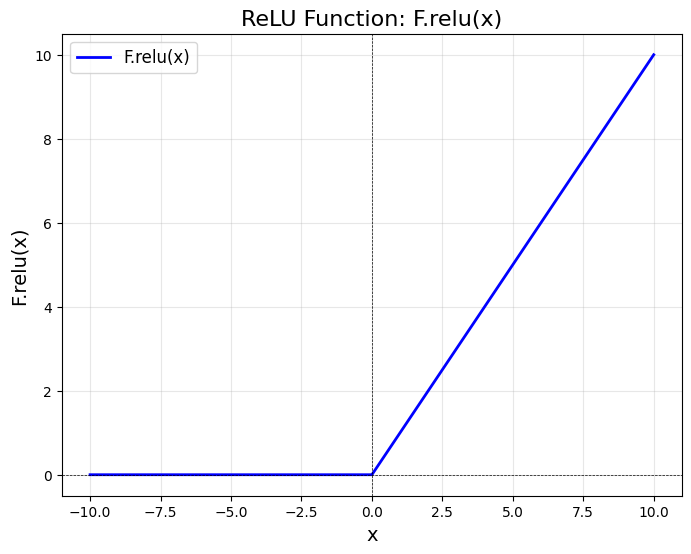

In [55]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Generate input values from -10 to 10
x = torch.linspace(-10, 10, 1000)  # 1000 points evenly spaced between -10 and 10
y = F.relu(x)  # Apply ReLU function

# Plot the ReLU function
plt.figure(figsize=(8, 6))
plt.plot(x.numpy(), y.numpy(), label='F.relu(x)', color='blue', linewidth=2)
plt.title('ReLU Function: F.relu(x)', fontsize=16)
plt.xlabel('x', fontsize=14)
plt.ylabel('F.relu(x)', fontsize=14)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.show()

This function then allows if the number is inferior to 0 be be equal to 0 else, it is a non 0 value.

In [57]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# Define the GNN model
class SimpleGNN(torch.nn.Module):
    def __init__(self, in_node_features, hidden_channels, out_channels):
        super(SimpleGNN, self).__init__()
        # Define two simple graph convolutional layers
        self.conv1 = GCNConv(in_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        #
        self.linear = torch.nn.Linear(hidden_channels, out_channels)  # Direct graph-level prediction

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)  # First GCN layer
        x = F.relu(x)  # Apply non-linearity
        x = self.conv2(x, edge_index)  # Second GCN layer
        #
        x = F.relu(x)
        # Instead of pooling, use the entire graph embedding
        x = self.linear(x.mean(dim=0))  # Generate graph-level output directly (no pooling)
        return x

### Training and evaluation function

In [58]:
# Training function
def train(loader, model, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in loader:
        optimizer.zero_grad()  # Reset gradients
        out = model(batch.x, batch.edge_index)  # Forward pass
        loss = criterion(out, batch.y)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        total_loss += loss.item()  # Accumulate loss
    return total_loss / len(loader)  # Average loss

# Validation function
def evaluate(loader, model, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():  # No gradient computation
        for batch in loader:
            out = model(batch.x, batch.edge_index)  # Forward pass
            loss = criterion(out, batch.y)  # Compute loss
            total_loss += loss.item()  # Accumulate loss
    return total_loss / len(loader)  # Average loss

### Run the GNN

In [59]:
# Instantiate the model
in_node_features = node_features.shape[1]
in_edge_features = edge_feat.shape[1]
hidden_channels = 64
out_channels = 1  # Assuming a regression task
model = SimpleGNN(in_node_features, hidden_channels, out_channels)

# Optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()  # Use CrossEntropyLoss for classification tasks

# Using the DataLoaders for training and validation
for epoch in range(1, 101):
    train_loss = train(train_loader,model,optimizer,criterion)
    val_loss = evaluate(val_loader,model,criterion)
    print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Test the model
test_loss = evaluate(test_loader,model,criterion)
print(f'Test Loss: {test_loss:.4f}')


/home/lorentyfle/test/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/lorentyfle/test/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1, Train Loss: 1.9301, Val Loss: 1.2328
Epoch: 2, Train Loss: 1.5731, Val Loss: 1.2745
Epoch: 3, Train Loss: 1.6087, Val Loss: 1.3357
Epoch: 4, Train Loss: 1.6133, Val Loss: 1.2288
Epoch: 5, Train Loss: 1.5433, Val Loss: 1.2378
Epoch: 6, Train Loss: 1.5592, Val Loss: 1.2089
Epoch: 7, Train Loss: 1.5853, Val Loss: 1.2284
Epoch: 8, Train Loss: 1.5600, Val Loss: 1.2245
Epoch: 9, Train Loss: 1.5430, Val Loss: 1.2445
Epoch: 10, Train Loss: 1.5430, Val Loss: 1.2577
Epoch: 11, Train Loss: 1.5662, Val Loss: 1.2073
Epoch: 12, Train Loss: 1.5444, Val Loss: 1.2193
Epoch: 13, Train Loss: 1.6058, Val Loss: 1.2682
Epoch: 14, Train Loss: 1.5733, Val Loss: 1.2403
Epoch: 15, Train Loss: 1.5482, Val Loss: 1.2343
Epoch: 16, Train Loss: 1.5502, Val Loss: 1.2847
Epoch: 17, Train Loss: 1.6010, Val Loss: 1.3006
Epoch: 18, Train Loss: 1.5368, Val Loss: 1.2381
Epoch: 19, Train Loss: 1.5484, Val Loss: 1.2334
Epoch: 20, Train Loss: 1.5521, Val Loss: 1.2295
Epoch: 21, Train Loss: 1.5391, Val Loss: 1.2806
E

Yes, the restults are very bad.

==> Explain why etc

# Application: Use of GNN to run an MD.